In [1]:
import random
import matplotlib.pyplot as plt 
%matplotlib inline
import torch
import torch.nn.functional as F 

In [2]:
# starter code
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos) # 27 

block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]* block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


**1. I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that (1) the network trains just fine or (2) the network doesn't train at all, but actually it is (3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.**

In [3]:
class LinearZero:
    def __init__(self,fan_in, fan_out):
        self.weight = torch.zeros((fan_in, fan_out)) # All zero values 
        self.bias = torch.zeros(fan_out) # Same as above

    def __call__(self, x):
        self.out = x @ self.weight + self.bias 
        return self.out 
    
    def parameters(self):
        return [self.weight, self.bias]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 

    def parameters(self):
        return []

In [4]:
n_embd = 10
n_hidden = 100 
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
   LinearZero(n_embd * block_size, n_hidden), Tanh(),
   LinearZero(n_hidden, n_hidden), Tanh(),
   LinearZero(n_hidden, n_hidden), Tanh(),
   LinearZero(n_hidden, n_hidden), Tanh(),
   LinearZero(n_hidden, n_hidden), Tanh(),
   LinearZero(n_hidden, vocab_size),
 ]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


46497


In [5]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2958
  10000/ 200000: 2.7882
  20000/ 200000: 2.7518
  30000/ 200000: 2.8506
  40000/ 200000: 2.8221
  50000/ 200000: 2.8987
  60000/ 200000: 2.6038
  70000/ 200000: 2.6751
  80000/ 200000: 3.0131
  90000/ 200000: 2.7753
 100000/ 200000: 2.6079
 110000/ 200000: 2.5273
 120000/ 200000: 2.6690
 130000/ 200000: 2.6426
 140000/ 200000: 2.8423
 150000/ 200000: 2.5484
 160000/ 200000: 2.9788
 170000/ 200000: 2.9535
 180000/ 200000: 2.8622
 190000/ 200000: 2.8513


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

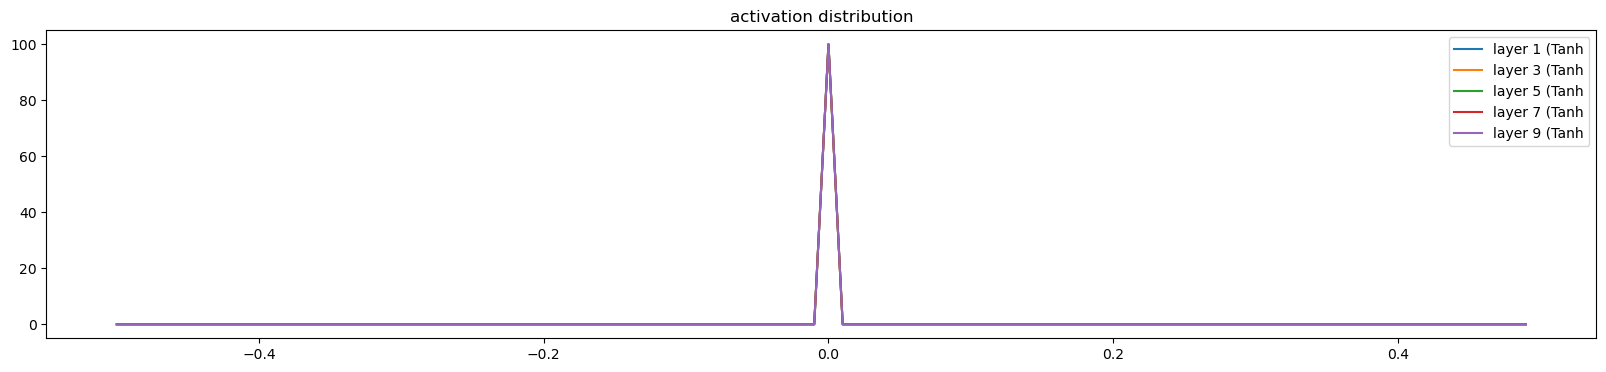

In [6]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

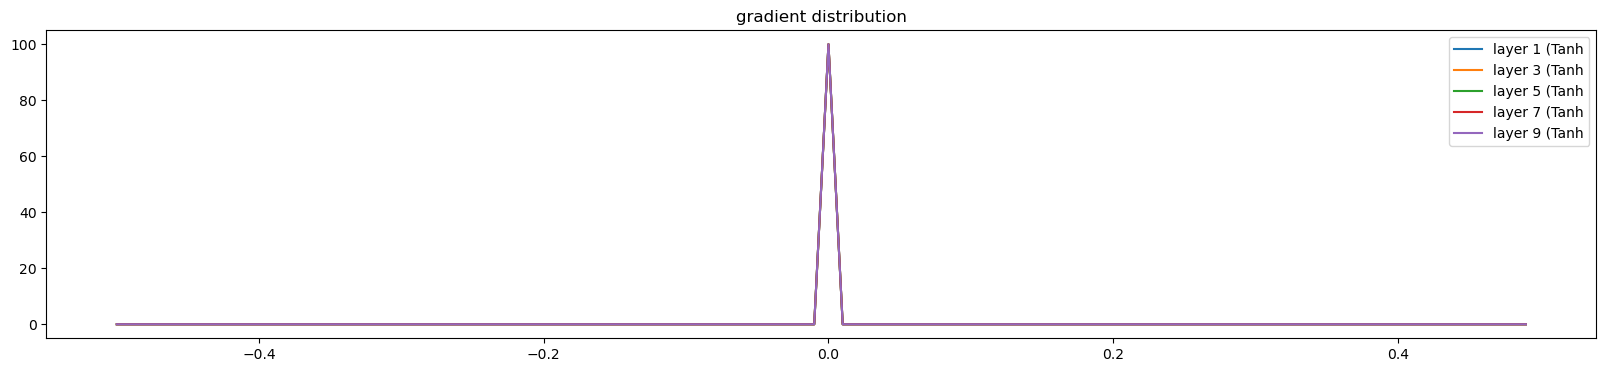

In [7]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


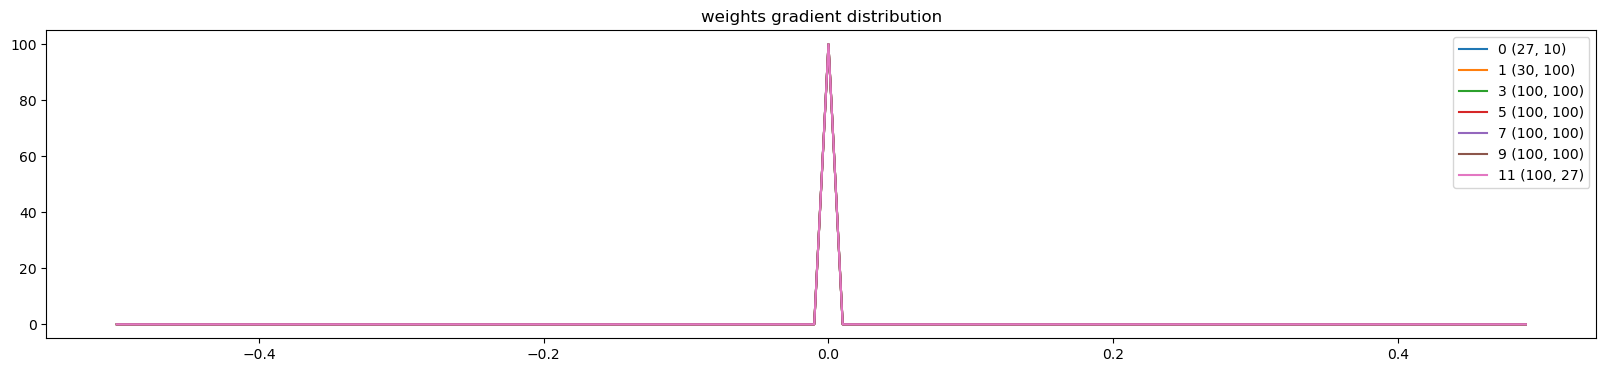

In [8]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

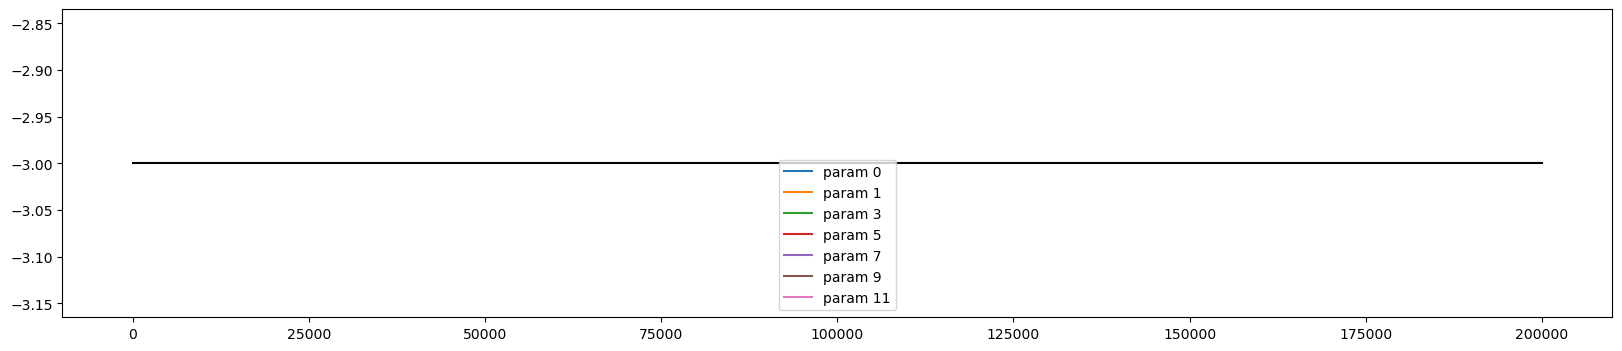

In [9]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

>- So it seems like all the weights and biases still remain 0 after all iterations. Since there is only one curve (color) in all the diagnostic plots, it seems that all the weights and biases have converged to the same normal. 
>- The standard deviations are all 0. And no neurons are activated at all. Which means the prediction for any input is the same. This also means that all those steps of gradient descent did not update the weights at all, or after updates somehow converged back to 0!

**2. BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.**

Let's see the final output $y$ of the Batch Normalization, and rewrite it to look like $wx + b$

$y = \gamma \cdot (\frac{wx+b - \mu}{\sqrt{\sigma^{2}+\epsilon}}) + \beta$

$y = \gamma \frac{wx}{\sqrt{\sigma^{2}+\epsilon}} + \gamma \frac{b}{\sqrt{\sigma^{2}+\epsilon}} - \gamma \frac{\mu}{\sqrt{\sigma^{2}+\epsilon}} + \beta$

$y = (\frac{ \gamma w}{\sqrt{\sigma^{2}+\epsilon}}) x + \gamma (\frac{b-\mu}{\sqrt{\sigma^{2}+\epsilon}}) + \beta$

$y = \hat{w}x + \hat{b}$

$\hat{w} = \frac{ \gamma w}{\sqrt{\sigma^{2}+\epsilon}}$

$\hat{b} = \gamma (\frac{b-\mu}{\sqrt{\sigma^{2}+\epsilon}}) + \beta$

In [10]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):    
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn(fan_out) if bias else None 
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum 
        self.training = True
        # Parameters that are trained with backprop 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Estimated on the fly, no backprop
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta 
        if self.training:
            self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean 
            self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar 
        return self.out  

    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
n_hidden = 100
C = torch.randn((vocab_size, n_embd), generator=g)
layers= [
  Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
 ]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True 

16651


In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  
  if i == max_steps:
    print(loss.item())

In [13]:
# Find the validation loss on the network post batch normalization 
@torch.no_grad()
def split_loss(split, layers):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] 
  x = emb.view(emb.shape[0], -1) 
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False

split_loss('val', layers)

val 2.1011855602264404


$\hat{w} = \frac{ \gamma w}{\sqrt{\sigma^{2}+\epsilon}}$

$\hat{b} = \gamma (\frac{b-\mu}{\sqrt{\sigma^{2}+\epsilon}}) + \beta$

In [14]:
# Fold the gamma and beta value into the weights of each layer, then check the validation loss  

modified_layers = []

with torch.no_grad():
    layers[0].weight = (layers[1].gamma * (layers[0].weight)) / (torch.sqrt(layers[1].running_var + layers[1].eps))
    layers[0].bias = (layers[1].gamma * (layers[0].bias - layers[1].running_mean) / ((torch.sqrt(layers[1].running_var + layers[1].eps)))) + layers[1].beta
    layers[3].weight = (layers[4].gamma * (layers[3].weight)) / (torch.sqrt(layers[4].running_var + layers[4].eps))
    layers[3].bias = (layers[4].gamma * (layers[3].bias - layers[4].running_mean) / ((torch.sqrt(layers[4].running_var + layers[4].eps)))) + layers[4].beta
    layers[6].weight = (layers[7].gamma * (layers[6].weight)) / (torch.sqrt(layers[7].running_var + layers[7].eps))
    layers[6].bias = (layers[7].gamma * (layers[6].bias - layers[7].running_mean) / ((torch.sqrt(layers[7].running_var + layers[7].eps)))) + layers[7].beta

for layer in layers:
    if not isinstance(layer, BatchNorm1d):
        modified_layers.append(layer)


In [15]:
for layer in modified_layers:
    print(layer.__class__.__name__)

Linear
Tanh
Linear
Tanh
Linear


In [16]:
split_loss('val', modified_layers)

val 2.1011857986450195
